In [1]:
import matplotlib
# matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np
import inspect
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import os
import sys
sys.path.append('.')
from scipy.ndimage import gaussian_filter1d

from datalib_logsph import DataSph, flag_to_species

from matplotlib.colors import LinearSegmentedColormap

cdata = {
    "red": [(0.0, 0.0, 0.0), (0.5, 0.0, 0.0), (0.55, 1.0, 1.0), (1.0, 1.0, 1.0),],
    "green": [(0.0, 1.0, 1.0), (0.45, 0.0, 0.0), (0.55, 0.0, 0.0), (1.0, 1.0, 1.0),],
    "blue": [(0.0, 1.0, 1.0), (0.45, 1.0, 1.0), (0.5, 0.0, 0.0), (1.0, 0.0, 0.0),],
}

hot_cold_cmap = LinearSegmentedColormap("hot_and_cold", cdata, N=1024, gamma=1.0)
if "hot_and_cold" not in matplotlib.colormaps:
    matplotlib.colormaps.register(hot_cold_cmap)




In [2]:
#if magnetar folder exists set to data
if os.path.isdir('../data/magnetar/'):
    data = DataSph('../data/magnetar/')
#data = DataSph('../data/magnetar/')
data_rthin_high = DataSph('../data/rthin_high/')
data_rthin_low = DataSph('../data/rthin_low/')
data_rwide = DataSph('../data/rwide/')


Base
fld keys are: ['B1', 'B2', 'B3', 'B_sqr', 'E1', 'E2', 'E3', 'E_sqr', 'J1', 'J2', 'J3', 'Rho_e', 'Rho_p', 'divB', 'divE', 'flux', 'step', 'time', 'B', 'J']
ptc keys are: ['step', 'time', 'tracked_ptc_E', 'tracked_ptc_flag', 'tracked_ptc_id', 'tracked_ptc_p1', 'tracked_ptc_p2', 'tracked_ptc_p3', 'tracked_ptc_weight', 'tracked_ptc_x1', 'tracked_ptc_x2', 'tracked_ptc_x3']
Derived
Base
fld keys are: ['B1', 'B2', 'B3', 'B_sqr', 'E1', 'E2', 'E3', 'E_sqr', 'J1', 'J2', 'J3', 'Rho_e', 'Rho_p', 'divB', 'divE', 'flux', 'step', 'time', 'B', 'J']
ptc keys are: ['step', 'time', 'tracked_ptc_E', 'tracked_ptc_flag', 'tracked_ptc_id', 'tracked_ptc_p1', 'tracked_ptc_p2', 'tracked_ptc_p3', 'tracked_ptc_weight', 'tracked_ptc_x1', 'tracked_ptc_x2', 'tracked_ptc_x3']
Derived
Base
fld keys are: ['B1', 'B2', 'B3', 'B_sqr', 'E1', 'E2', 'E3', 'E_sqr', 'J1', 'J2', 'J3', 'Rho_e', 'Rho_p', 'divB', 'divE', 'flux', 'step', 'time', 'B', 'J']
ptc keys are: ['step', 'time', 'tracked_ptc_E', 'tracked_ptc_flag', 'tra

In [ ]:
data_rwide.conf

In [22]:
#A debug class object
class debugging:
    def __init__(self, enabled=False):
        self.enabled = enabled
        self.level = 0 #allows for different debug messages

debug = debugging(enabled=False)

#Defines the function that will be used to calculate the quantity
#This class will also store the arguments necessary for plotting the function
class fld_quantity:
    def __init__(self, func,**kwargs):
        self.func = func
        self.kwargs = kwargs
        self.name = kwargs.get('name', None)

        self.set_plot_defaults()

        

    def set_plot_defaults(self):

        #colorbar defaults
        self.vmin = self.kwargs.get('vmin', None)
        self.vmax = self.kwargs.get('vmax', None)
        self.cmap = self.kwargs.get('cmap', "hot_and_cold")
        self.shading = self.kwargs.get('shading', 'gouraud')
        #self.norm = kwargs.get('norm', colors.Normalize(vmin=self.vmin, vmax=self.vmax)) #This is already default
        #If you change norm you would need to ensure it has the current vmin and vmax
        '''        #I don't think we need these cbar, you can make your own plotting function
        #colorbar placement and scaling #shouldn't need to change these much
        self.cbar_position = kwargs.get('cbar_position', 'right')
        self.cbar_size = kwargs.get('cbar_size', '5%')
        self.cbar_pad = kwargs.get('cbar_pad', '0.05')
        '''
        #plot limits
        self.xlim = self.kwargs.get('xlim', None)
        self.ylim = self.kwargs.get('ylim', None)
        self.aspect = self.kwargs.get('aspect', 'equal')

        #plot labels
        self.title  = self.name
        self.fontsize = self.kwargs.get('fontsize', 24) ########################Consider making this a title_fontsize ##or consider a general method
        
    

        
        
    def __str__(self):
        # A overinformative string representation
        kwargs_str = ', '.join(f'{key}={value}' for key, value in self.kwargs.items())
        return f"fld_quantity with function {self.func.__name__} and kwargs: {kwargs_str}"
    
    


In [23]:
EdotB = fld_quantity(
                     lambda data: data.E1*data.B1 + data.E2*data.B2 + data.E3*data.B3,
                     name = 'EdotB',
                     vmin = -1,
                     vmax = 1,
                     )

JdotB = fld_quantity(
                    lambda data: data.J1*data.B1 + data.J2*data.B2 + data.J3*data.B3,
                    name = 'JdotB',
                    vmin = -1,
                    vmax = 1,
                    )

In [34]:
def draw_field_lines_sph(ax,dataset,**kwargs):
    Bp      = dataset.conf["Bp"]
    flux    = np.cumsum(dataset.B1 * dataset._rv * dataset._rv * np.sin(dataset._thetav) * dataset._dtheta, axis=0)
    clevels = np.linspace(0.0, np.sqrt(Bp), 10)**2
    ax.contour(dataset.x1, dataset.x2, flux, clevels
             , colors='green', linewidths=1)

#draw_twist_tubes is for the magnetar twisted magnetosphere setup
#this requires the Bp parameter to be set in the dataset
#and twist_rmax_1 and twist_rmax_2 to be set in the dataset.conf
def draw_twist_tubes(ax,dataset,**kwargs):
    Bp    = dataset.conf["Bp"]
    flux  = np.cumsum(dataset.B1 * dataset._rv * dataset._rv 
                    * np.sin(dataset._thetav) * dataset._dtheta, axis=0)

    rmaxs = [dataset.conf['twist_rmax_1'],dataset.conf['twist_rmax_2']]
    fluxs = [Bp/rmax for rmax in rmaxs]
    ax.contour(dataset.x1, dataset.x2, flux, fluxs, colors='green', linewidths=2)


def draw_NS(ax,dataset,**kwargs): #just need dataset for convention
    r = kwargs.get("Radius",1)
    ax.add_patch(plt.Circle((0,0),r,fill=True, color="black", alpha=0.5))

    

In [5]:
#fld_val is a class object that contains the function and the arguments to be plotted
def colorplot(ax,dataset,fld_val,**kwargs): 

    #first we access all plot_parameters from fld_val by signature inspection
    pcolormesh_sig = inspect.signature(ax.pcolormesh)
    #grabbing all the parameters of pcolormesh from fld_val
    plot_params = {}
    for attr in dir(fld_val):
        #check if the attribute is a parameter of pcolormesh
        if not callable(getattr(fld_val, attr)) and not attr.startswith("__") and attr in pcolormesh_sig.parameters and not attr == 'kwargs':

            plot_params[attr] = getattr(fld_val, attr)
        
    #updating plot_params with kwargs
    plot_params.update(kwargs) #just in case we wish to overwrite something with the overarching plot function

    #printing parameters if debugging is enabled
    if debug.enabled: print(f"{fld_val.name} colorplot attributes", plot_params)

    c = ax.pcolormesh(dataset.x1, dataset.x2, fld_val.func(dataset), **plot_params)
    
    #include the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05) ###############################consider making this a parameter inside fld_val
    cbar = plt.colorbar(c, cax=cax)

    #Don't think I need to return anything

#A function that sets the limits of a plot
def set_plot_characteristics(ax,fld_val,**kwargs):

    #There might be a way to do this with accessing signatures
    #however, it could get complicated with different naming conventions
    #So I will just hardcode the possible parameters
    
    
    # This requires that fld_val has the following attributes:
    # xlim, ylim, aspect, title, fontsize
    attrs = ['xlim', 'ylim', 'aspect', 'title', 'fontsize']
    for attr in attrs:
        #just checking if there else make some error 
        if not hasattr(fld_val, attr):
            raise ValueError(f"fld_val must have attribute {attr}")
    
    if debug.enabled: 
        #where fld_val attr match attrs
        for attr in attrs:#makes a dict of the attributes
            fld_attrs = {attr: getattr(fld_val, attr) for attr in attrs}
        print(f"{fld_val.name} plot attributes", fld_attrs)


    
    ax.set_xlim(kwargs.get('xlim', fld_val.xlim))
    ax.set_ylim(kwargs.get('ylim', fld_val.ylim))
    ax.set_aspect(kwargs.get('aspect', fld_val.aspect))
    ax.tick_params(axis='both', which='major', labelsize=kwargs.get('fontsize', fld_val.fontsize))

    ax.set_title(kwargs.get('title', fld_val.title), fontsize=kwargs.get('fontsize', fld_val.fontsize))
    
    

In [ ]:
data = data_rthin_high
print(data.x1[0][0])
max_x1 = data.x1.max()
min_x1 = data.x1.min()
print(max_x1, min_x1)


In [6]:
def rescale_figure(figsize,target_size=13):
    width, height = figsize
    aspect = width/height

    if aspect > 1:
        figsize = (target_size, target_size/aspect)
    else:
        figsize = (target_size*aspect, target_size)

    return figsize

In [26]:
#This default figure only allows for horizontal or vertical orientation
##i.e no 2x2 or 2x3 etc
def default_figure(dataset, fld_quantities, **kwargs):

    orient = kwargs.get('orient', 'horizontal')

    num_flds = len(fld_quantities)

    
    #Loops through the field quantities to find the appropriate size of the figure
    total_xsize = 0
    largest_xsize = 0
    total_ysize = 0
    largest_ysize = 0
    for fld_val in fld_quantities:

        #finds the xsize of the subplot
        if fld_val.xlim is not None:
            xsize = fld_val.xlim[1] - fld_val.xlim[0]
        else:
            xsize = np.ceil(dataset.x1.max()) - np.floor(dataset.x1.min())

        #finds the ysize of the subplot
        if fld_val.ylim is not None:
            ysize = fld_val.ylim[-1] - fld_val.ylim[0]
        else:
            ysize = np.ceil(dataset.x2.max()) - np.floor(dataset.x2.min())
        
        #updates the largest,total sizes
        total_xsize += xsize
        largest_xsize = xsize if xsize > largest_xsize else largest_xsize
        total_ysize = ysize if ysize > total_ysize else total_ysize
        largest_ysize += ysize

    if orient == 'horizontal':
        figsize = total_xsize, largest_ysize
        fig, ax  = plt.subplots(ncols=num_flds)
    elif orient == 'vertical':
        figsize = largest_xsize, total_ysize
        fig, ax  = plt.subplots(nrows=num_flds)
    else:
        raise ValueError("orient must be either 'horizontal' or 'vertical'")
    
    figsize = rescale_figure(figsize, target_size=kwargs.get('target_figsize', 13))
    if debug.enabled: print(f"Default figure size: {figsize}")

    fig.set_size_inches(figsize)
    
    return fig, ax
     

    

In [52]:
#This will plot the figure of a single dataset with various field quantities
# Currently it will allow for either horizontal  vertical display,
# no 2x2 or 3x3 etc. display
def plot_fig(n,dataset,fld_quantities, **kwargs):

    #First ensuring that n,datasets, and fld_quantities are correct type
    assert isinstance(n,int), "n must be an integer"
    if not isinstance(fld_quantities,list):
        fld_quantities = [fld_quantities]
    
    num_flds = len(fld_quantities)
    if debug.enabled: print(f"Number of fld_quantities: {num_flds}")
    
    ##setting the subplots depending on the get_figure function
    get_fig_func = kwargs.get("get_figure", default_figure)
    fig,ax = get_fig_func(dataset,fld_quantities, **kwargs)

    #loading the dataset
    dataset.load_fld(n)

    time = dataset.time
    for i in range(num_flds):

        #load the field value which is a class object
        fld_val = fld_quantities[i]

        
        #plotting the colorplot
        colorplot(ax[i],dataset,fld_val)
        #setting the plot characteristics
        set_plot_characteristics(ax[i],fld_val)
        
        # Doing any post processing on the axis
        # Such as drawing field lines, NS, etc
        for ax_func in kwargs.get('axis_post_processing') if 'axis_post_processing' in kwargs else []:
            ax_func(ax[i],dataset)
        

    #Doing any post processing on the figure as a whole
    # Such as showing the time
    for fig_func in kwargs.get('figure_post_processing') if 'figure_post_processing' in kwargs else []:
        fig = fig_func(fig,dataset,**kwargs)

    fig.tight_layout(pad=1.0)

    return fig
    



    #setting up the figure parameters with **kwargs



In [29]:
debug.enabled = True

In [30]:
EdotB.xlim = [0,15]
EdotB.ylim = [-5,5]
JdotB.xlim = [0,15]
JdotB.ylim = [-5,5]
EdotB.title = 'EdotB'
JdotB.title = 'JdotB'

In [90]:
def find_top_right_subplot(fig):
    max_x1 = -1
    max_y1 = -1
    top_right_subplot = None
    
    for ax in fig.axes:
        bbox = ax.get_position()
        # Check if this subplot is further right and up than the current max
        if bbox.x1 >= max_x1 and bbox.y1 >= max_y1:
            max_x1, max_y1 = bbox.x1, bbox.y1
            top_right_subplot = ax
            
    return top_right_subplot

In [103]:
def show_time(fig,dataset,**kwargs):
    time = dataset.time
    # Adjust the top margin to make space for the text
    top_right = find_top_right_subplot(fig)
    #fig.subplots_adjust(top=0.85) 
    top_right.text(0.0, 1.1, r"$t = %.1fr_g/c$" % time, fontsize=24, transform=top_right.transAxes)
    #fig.text(x,y,f"t = {time:.2f}", fontsize=24,color = 'blue')
    return fig

Number of fld_quantities: 2
Default figure size: (20, 13.333333333333334)
EdotB colorplot attributes {'cmap': 'hot_and_cold', 'shading': 'gouraud', 'vmax': 1, 'vmin': -1}
EdotB plot attributes {'xlim': [0, 15], 'ylim': [-5, 5], 'aspect': 'equal', 'title': 'EdotB', 'fontsize': 24}
JdotB colorplot attributes {'cmap': 'hot_and_cold', 'shading': 'gouraud', 'vmax': 1, 'vmin': -1}
JdotB plot attributes {'xlim': [0, 15], 'ylim': [-5, 5], 'aspect': 'equal', 'title': 'JdotB', 'fontsize': 24}


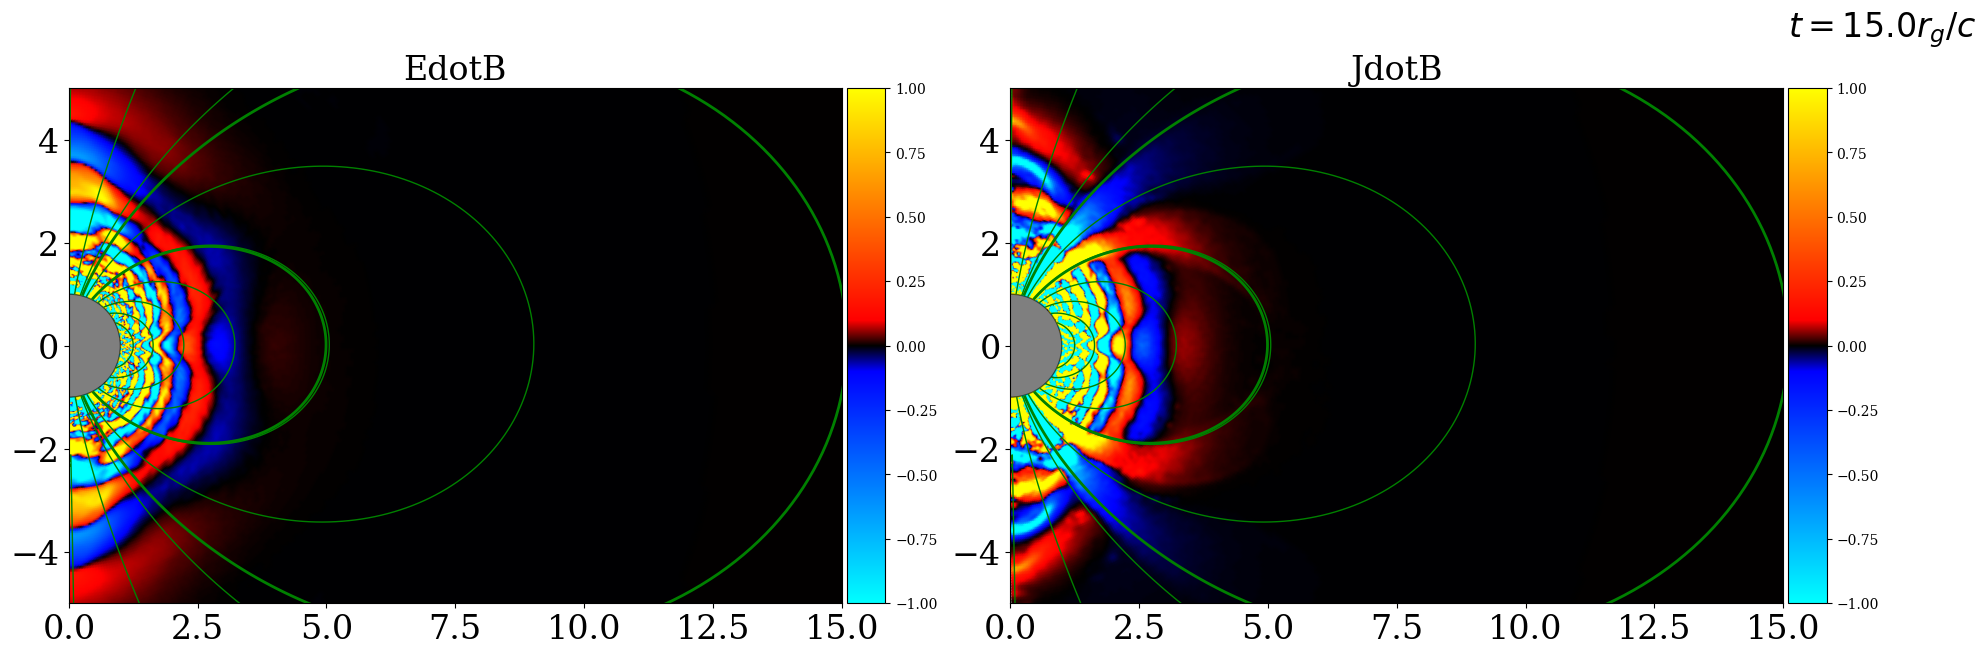

In [104]:
step = 50
datasets = data_rthin_high      # These are just the datasets loaded in with the DataSph class
fld_quantities = [EdotB,JdotB]  # These will be class objects defining the plotting functions

# These are functions that are applied to each subplot altering the axis object
# These functions need to take at least func(ax,dataset) as arguments
axis_post_processing = [draw_twist_tubes
                       ,draw_field_lines_sph
                       ,draw_NS]       
#Would it make sense to make a figure-like class where I can have my functions
figure_post_process = [show_time]        # These are functions that are applied to the figure after all subplots are drawn
post_process = []               # Potential other post processing that isn't so simpled

_= plot_fig(step, datasets, fld_quantities
           ,axis_post_processing = axis_post_processing
           ,figure_post_processing = figure_post_process
           , orient = "horizontal", target_figsize=20)

I think to make the adding time as a thing work. One way is to look at the figure size, add to the vertical size, whatever is necessary to fit the text,this way it will not affect the size of the subplots or their relative aspects.

Additionally, it is possible I just did fig_text wrong It might be possible to just have it work
